In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.svm import SVC
import pywt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import preprocessing
import seaborn as sns
import pickle 
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import tempfile
from tensorflow import keras
import tensorflow_model_optimization as tfmot

import tensorflow as tf
# import tensorflow_addons as tfa

import os

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)
    
# print(tf.__version__)

c:\Users\21379\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Creation de la data complete

iitd = []   # , casia phonix, mmu
Liitd = []     # , Lcasia,LPho,  Lmmu

datasets = ['phoenix']   # 'iitd', 'casiaclean',
start = [3]   # ,3,5
data = [iitd]  # iitd, casia,
labels = [Liitd]  # Liitd, Lcasia,

for d, s, images, label in zip(datasets, start, data, labels ):
    for root, dirr, imgs in os.walk(f'data/aug/{d}'):
            for img in imgs:
                if ((img.endswith('bmp')) or (img.endswith('png')) or (img.endswith('jpg'))) :
                    path = os.path.join(root,img)  
                    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    images.append(image)
                    label.append(f'{d[:4]}_{img[:s]}')

LE = preprocessing.LabelEncoder()
labels_id_iitd = list(LE.fit_transform(Liitd)) 
labels_dic_iitd = {k:v for k,v in zip(Liitd,labels_id_iitd)}
                                                        
iitd = np.array(iitd)
labels_id_iitd = np.array(labels_id_iitd) 

print('nbr de class pheonix',max(labels_id_iitd))


nbr de class pheonix 63


In [ ]:
## to check if data are balanced

# f , n = np.unique(labels_id_casia, return_counts=True) 
# r = np.where(n < 20)[0]

# for i in range(len(r)):
#     print([k for (k,v) in labels_dic_casia.items() if v == r[i]])
    
# print(min(n))
# print(max(n))
# sns.set(rc={'figure.figsize':(25,10)})
# sns.countplot(labels_id_casia, color='red')

In [ ]:
# # # to balance classes 
# data_bal=[]
# labels_bal=[]
# for i,j in zip(labels_id_casia,casia) :
#     if (labels_bal.count(i)<20):
#         data_bal.append(j)
#         labels_bal.append(i)
        
# labels_id22 = list(LE.fit_transform(labels_bal))

# num_classes = max(labels_id22)+1
# print(f'nbr of classes is {num_classes}')    
# print(len(data_bal))     
# f, n = np.unique(labels_bal, return_counts=True)
# plt.figure(figsize=(25,10))
# plt.plot(f,n)
# plt.show()
# print(min(n))   
# data_bal = np.array(data_bal)
# labels_id22 = np.array(labels_id22) 

In [3]:
xtr, xts, ytr, yts = train_test_split(iitd,labels_id_iitd, test_size=0.2)

In [ ]:
# dynamic learning rate
def exponential_decay(lr0, s):     # i need to search what is s and wch kayen type of learning rate schedulers mais mzl i didnt use it yet hada but fhamt wch aw sari.
    def exponential_decay_fn(epoch):       # this is an inner function, 3ndhom many uses hado such as : encapsulation and preserve the inner function from ga3 wch ysra bara l outter function
        return lr0 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)   # callbacks : fct li they take as argument other functions

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

In [15]:
CNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128,128,1)),
    tf.keras.layers.Conv2D(96, (11,11), strides = (4,4), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.ZeroPadding2D(padding= (2,2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.ZeroPadding2D(padding= (1,1)),
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='softmax')
                            ])
CNN.compile( optimizer='adam', loss="sparse_categorical_crossentropy",  metrics= 'accuracy')
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 96)        11712     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 96)       0         
 2D)                                                             
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 19, 19, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 16)        13840     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                      

In [5]:
# CNN training   (we need to do it ki b svm ki blach)
history = CNN.fit(
    xtr,ytr,
    # batch_size = 32,
    validation_split=0.15,      # xval necreyiha apres
    # callbacks=[lr_scheduler, early_stopping],
    epochs=32
)

Epoch 1/32
96/96 [==============================] - 34s 290ms/step - loss: 5.5558 - accuracy: 0.0039 - val_loss: 5.2875 - val_accuracy: 0.0149
Epoch 2/32
96/96 [==============================] - 28s 289ms/step - loss: 5.1807 - accuracy: 0.0246 - val_loss: 5.0828 - val_accuracy: 0.0260
Epoch 3/32
96/96 [==============================] - 28s 291ms/step - loss: 4.8032 - accuracy: 0.0489 - val_loss: 4.6413 - val_accuracy: 0.0706
Epoch 4/32
96/96 [==============================] - 27s 285ms/step - loss: 4.2190 - accuracy: 0.0965 - val_loss: 3.7186 - val_accuracy: 0.1580
Epoch 5/32
96/96 [==============================] - 27s 286ms/step - loss: 3.5585 - accuracy: 0.1743 - val_loss: 3.4525 - val_accuracy: 0.2026
Epoch 6/32
96/96 [==============================] - 27s 286ms/step - loss: 2.9329 - accuracy: 0.2764 - val_loss: 2.8333 - val_accuracy: 0.3104
Epoch 7/32
96/96 [==============================] - 27s 286ms/step - loss: 2.4521 - accuracy: 0.3743 - val_loss: 2.2968 - val_accuracy: 0.4145

In [6]:
# loss, acc = CNN.evaluate(xts,yts)

28/28 [==============================] - 1s 50ms/step - loss: 1.2349 - accuracy: 0.7913


In [ ]:
# CNN.save('test.h5', save_format='h5')
# test = tf.keras.saving.load_model('mmu_86_43_test_86_11_val_92_79_train.h5', compile=False) 

In [7]:
# CNN.save_weights('iitd_79_test.model')

In [56]:
CNN.load_weights('model_save/phonix/without_pruning/phonix_0-86test.model')

In [7]:

# _, keras_file = tempfile.mkstemp('.h5')
# tf.keras.models.save_model(CNN, keras_file, include_optimizer=False)
# print('Saved baseline model to:', keras_file)


# hadi it saves bsh i didnt try yet to load the model ysma idk wila i ll have the same problem as model.save wla lala

Saved baseline model to: C:\Users\21379\AppData\Local\Temp\tmp1qfk0urn.h5


In [61]:

# Compute end step to finish pruning after 32 epochs.  (hanseyi 32 kima f training ta3 without pruning)

validation_split = 0.15 
num_images = xtr.shape[0] * (1 - validation_split)

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0
                                                               ,end_step=np.ceil(num_images).astype(np.int32))
}

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(CNN, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_for_pruning.load_weights('model_save/phonix/with_pruning/phonix_86_wella_93-76_with_pruned_model_wow.model')
model_for_pruning.summary()

# after compiling this li n9dro ndiro i believe load weights

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 30, 30, 96)       23330     
 9 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 15, 15, 96)       1         
 ling2d_9 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_zero_pa  (None, 19, 19, 96)       1         
 dding2d_6 (PruneLowMagnitud                                     
 e)                                                              
                                                                 
 prune_low_magnitude_conv2d_  (None, 17, 17, 16)       27666     
 10 (PruneLowMagnitude)                               

In [19]:
# traning with pruning (before saving the weights hadi)
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(xtr, ytr,
                  epochs= 32,
                  validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/32


c:\Users\21379\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 27s 325ms/step - loss: 4.4785 - accuracy: 0.0247 - val_loss: 3.9769 - val_accuracy: 0.0430
Epoch 2/32
50/50 [==============================] - 21s 411ms/step - loss: 3.7704 - accuracy: 0.0728 - val_loss: 3.8915 - val_accuracy: 0.0932
Epoch 3/32
50/50 [==============================] - 15s 309ms/step - loss: 3.4494 - accuracy: 0.1373 - val_loss: 3.1384 - val_accuracy: 0.1541
Epoch 4/32
50/50 [==============================] - 18s 358ms/step - loss: 2.8848 - accuracy: 0.2297 - val_loss: 2.7788 - val_accuracy: 0.2115
Epoch 5/32
50/50 [==============================] - 16s 327ms/step - loss: 2.3739 - accuracy: 0.3639 - val_loss: 2.1063 - val_accuracy: 0.3978
Epoch 6/32
50/50 [==============================] - 18s 366ms/step - loss: 1.9536 - accuracy: 0.4285 - val_loss: 1.9653 - val_accuracy: 0.4552
Epoch 7/32
50/50 [==============================] - 15s 291ms/step - loss: 1.5842 - accuracy: 0.5278 - val_loss: 1.4151 - val_accuracy: 0.5950
Epoch 8/32

In [62]:
loss, acc = model_for_pruning.evaluate(xts, yts)

c:\Users\21379\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 2s 70ms/step - loss: 0.3388 - accuracy: 0.9376


In [63]:
# model_for_pruning.save_weights('phonix_86_wella_93-76_with_pruned_model_wow.model')

In [ ]:
# # cross validation bsh 9er3a for computer vision

# num_classes = 44
# def CNN () :
#     CNN = tf.keras.models.Sequential([
#         tf.keras.layers.Input(shape=(128,128,1)),
#         tf.keras.layers.Conv2D(96, (11,11), strides = (4,4), activation='relu'),
#         tf.keras.layers.MaxPool2D(),
#         tf.keras.layers.ZeroPadding2D(padding= (2,2)),
#         tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPool2D(),
#         tf.keras.layers.ZeroPadding2D(padding= (1,1)),
#         tf.keras.layers.Conv2D(8, (5, 5), activation='relu'),
#         tf.keras.layers.MaxPool2D(),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(4096, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(2048, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#                                 ])
#     CNN.compile( optimizer='adam', loss="sparse_categorical_crossentropy",  metrics= 'accuracy')
#     return CNN

# # tfa.metrics.F1Score(num_classes= 44, average='micro')
# # CNN.summary()

# def display_cv_results(search_results):
#     print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
#     means = search_results.cv_results_['mean_test_score']
#     stds = search_results.cv_results_['std_test_score']
#     params = search_results.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param)) 
        
# from sklearn.model_selection import KFold

# kfold = KFold(n_splits=5, shuffle=True)
# model = KerasClassifier(build_fn=CNN)
# param_grid = {
#     'batch_size': [16, 32, 64],
#     'epochs': [20,30,40],
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'accuracy', cv=kfold)
# grid_result = grid.fit(mmu,labels_id_mmu)  # fit the full dataset as we are using cross validation 

# display_cv_results(grid_result)   

# # cross val b sklearn
# from sklearn.model_selection import cross_validate

# _scoring = ['accuracy', 'precision', 'recall', 'f1']
# results = cross_validate(estimator=CNN,
#                                X=xtr,
#                                y=ytr,
#                                cv= 5,
#                                scoring=_scoring,
#                                return_train_score=True)

In [67]:
model_for_pruning.pop() # it will remove the last layer
model_for_pruning.summary() # check the network 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 30, 30, 96)       23330     
 9 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 15, 15, 96)       1         
 ling2d_9 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_zero_pa  (None, 19, 19, 96)       1         
 dding2d_6 (PruneLowMagnitud                                     
 e)                                                              
                                                                 
 prune_low_magnitude_conv2d_  (None, 17, 17, 16)       27666     
 10 (PruneLowMagnitude)                               

In [25]:
# feature extraction with wavelet

WaveletTrain = []
WaveletTest = []

for i in range(len(xtr)):
  LLtr = pywt.dwt2(xtr[i], 'bior2.2' )[0].astype('uint8')
  LLtr = np.reshape( LLtr , (LLtr.shape[0]*LLtr.shape[1],))
  WaveletTrain.append(LLtr) 

for k in range(len(xts)):
  LLts = pywt.dwt2(xts[k], 'bior2.2' )[0].astype('uint8')
  LLts = np.reshape( LLts , (LLts.shape[0]*LLts.shape[1],))
  WaveletTest.append(LLts)
 
WTr_feat = np.array(WaveletTrain)
WTs_feat = np.array(WaveletTest)

In [ ]:
WTr_feat.shape

In [26]:
kernel = cv2.getGaborKernel( ksize= (5,5) , sigma= 1 ,theta= 0,lambd= 1*np.pi/4 ,gamma= 0, psi= 0)
Gabor = cv2.filter2D(image,-1, kernel= kernel)

# feature extraction with wavelet

GaborTrain = []
GaborTest = []

for i in range(len(xtr)):
  gabtr = cv2.filter2D(xtr[i],-1, kernel= kernel)
  gabtr = np.reshape( gabtr , (gabtr.shape[0]*gabtr.shape[1],))
  GaborTrain.append(gabtr) 

for k in range(len(xts)):
  gabts = cv2.filter2D(xts[k],-1, kernel= kernel)
  gabts = np.reshape( gabts , (gabts.shape[0]*gabts.shape[1],))
  GaborTest.append(gabts)
 
GTr_feat = np.array(GaborTrain)
GTs_feat = np.array(GaborTest)

In [68]:
CNN_train_feat = model_for_pruning(xtr)      # tmed vecteur fih 751 lignes (nbr des images) et chaque lignes c l features 
CNN_test_feat = model_for_pruning(xts)

train_feat_W = np.hstack((CNN_train_feat, WTr_feat))    # Wtr c features men wavelat jayin de la forme  tan chaque ligne image, aya donc nconcateniw horzotalement bch yjona ga3 l features
test_feat_W = np.hstack((CNN_test_feat, WTs_feat))

train_feat_G = np.hstack((CNN_train_feat, GTr_feat))    # Wtr c features men wavelat jayin de la forme  tan chaque ligne image, aya donc nconcateniw horzotalement bch yjona ga3 l features
test_feat_G = np.hstack((CNN_test_feat, GTs_feat))



In [ ]:
print(train_feat_G.shape)
print(ytr.shape)

In [69]:
clf = SVC()
clf.fit(CNN_train_feat, ytr)
pred = clf.predict(CNN_test_feat)

In [71]:
# to save svm model
filename = 'one_dense_svm_phonix_with_pruning_91.sav'
pickle.dump(clf, open(filename, 'wb'))
# test = pickle.load(open(filename, 'rb'))
# result = test.score(CNN_test_feat, yts)
# print(result)

In [50]:
clf_W = SVC()
clf_W.fit(train_feat_W, ytr)
pred_W = clf_W.predict(test_feat_W)

In [51]:
clf_G = SVC()
clf_G.fit(train_feat_G, ytr)
pred_G = clf_G.predict(test_feat_G)

Accuracy :  0.9161290322580645


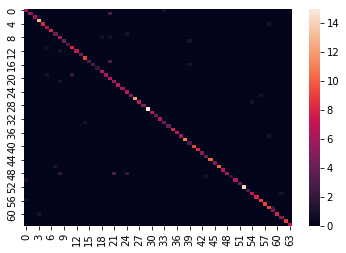

In [70]:
cm = confusion_matrix(yts,pred)
heatmap(cm)

accuracy = float(cm.diagonal().sum())/len(yts)
print("Accuracy : ", accuracy)

Accuracy :  0.8172043010752689


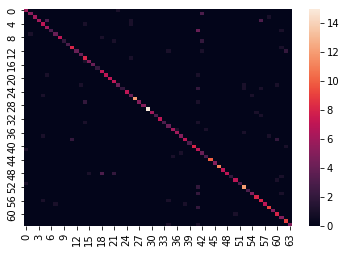

In [53]:
cmW = confusion_matrix(yts,pred_W)
heatmap(cmW)

accuracyW = float(cmW.diagonal().sum())/len(yts)
print("Accuracy : ", accuracyW)

Accuracy :  0.8838709677419355


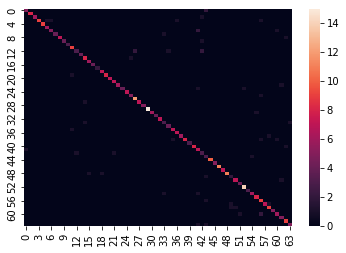

In [54]:
cmG = confusion_matrix(yts,pred_G)
heatmap(cmG)

accuracyG = float(cmG.diagonal().sum())/len(yts)
print("Accuracy : ", accuracyG)

## 1st try with mixed datasets 
Results : EPOCHS = 20
- CNN pure : acc = 0.40 (0.28)
- CNN brk + svm (sans dense) : acc = 0.367
- 2 dense (4000 + 2000 ) + svm : acc = 0.44  (0.01)
- 1 dense (4000) + svm : acc = 0.61

- 2 dense + wavelet + svm : acc = 0.005319148936170213
- 1 dense + wavelet + svm : acc = 0.015957446808510637

Conclusion : mafihach wavelet for feature extraction
i think we need ndiro cross validation psk kolma ybdl chwiya fhadak train testsplit ytbdl l resultat bzaaaaf ...

## 2nd try with seperate datasets :
IITD :  20 / 32 epochs
- CNN pure : train : 85.85   test 78.79  / train:  0.9443 val: 0.8961  test: 0.9011    
 train:  0.9209 val: 0.7788  test: 0.7913    

- CNN 2 dense + svm : 0.7701 / 0.7879464285714286 (with cnn 79)
- CNN 2 dense + wavelet + svm : 0.3103 / 0.32142857142857145
- CNN 2 dense + Gabor + svm : 0.7031 / 0.6752232142857143

- CNN 1 dense + svm : 0.7824 /  0.8493303571428571
- CNN 1 dense + wavelet + svm : 0.2422 / 0.28013392857142855
- CNN 1 dense + Gabor + svm : 0.6920 / 0.6674107142857143

- CNN 0 dense + svm : 0.7545 / 0.8203125
- CNN 0 dense + wavelet + svm : 0.375 / 0.3638392857142857
- CNN 0 dense + Gabor + svm : 0.7154 / 0.6774553571428571







mmu : 20 / 32 epochs

- CNN pure train : 0.8292 , test : 0.7786   / train 0.9013, val 0.7460, test : 0.7405

- CNN 2 dense + svm : 0.8428571428571429  / 0.7214
- CNN 2 dense + wavelet + svm : 0.75     / 0.7523
- CNN 2 dense + Gabor + svm : 0.7309     / 0.6976

- CNN 1 dense + svm : 0.8142857142857143   /   0.6785714285714286
- CNN 1 dense + wavelet + svm : 0.7095238095238096 /  0.7071428571428572
- CNN 1 dense + Gabor + svm : 0.7 / 0.6547619047619048

- CNN 0 dense + svm : 0.6095238095238096
- CNN 0 dense + wavelet + svm : 0.8333333333333334
- CNN 0 dense + Gabor + svm : 0.7428571428571429

why wavelet on mmu better than wavelet on iitd :
iitd fiha bzf variations and wavelet ynahi l high freq qhich means ya3mi bzf l image and ynahi l texture so machi
adapté l images lifihom high variations kima iitdm par contre gabor non. and that s why fl cas ta3 mmu both mchaw bien, 
ps mmu les images jayin homogenes, like mafihomch variations bzf so wavelet maya3mihach fihom.



casia :  (30 ep : 0.8763, test : 0.8201) (epochs 20 : train : 0.8318 test : 0.8044) 


phonix : 32 epochs
- CNN pure : train 0.9532  val 0.8817 test 0.8688

- CNN 2 dense + svm : 0.9376344086021505
- CNN 2 dense + wavelet + svm : 0.7935483870967742
- CNN 2 dense + Gabor + svm : 0.8580645161290322

- CNN 1 dense + svm : 0.7956989247311828
- CNN 1 dense + wavelet + svm : 0.7827956989247312
- CNN 1 dense + Gabor + svm : 0.8451612903225807

- CNN 0 dense + svm : 0.6774193548387096
- CNN 0 dense + wavelet + svm : 0.7956989247311828
- CNN 0 dense + Gabor + svm : 0.875268817204301


pheonix with pruning :

- CNN pure : tr : 0.9854 val : 0.9319 ts : 0.9376 

- CNN 2 dense + svm : 0.9225806451612903
- CNN 2 dense + wavelet + svm : 0.7935483870967742
- CNN 2 dense + Gabor + svm : 0.864516129032258

- CNN 1 dense + svm : 0.9161290322580645
- CNN 1 dense + wavelet + svm : 0.7784946236559139 
- CNN 1 dense + Gabor + svm : 0.8559139784946237

- CNN 0 dense + svm : 0.8903225806451613
- CNN 0 dense + wavelet + svm : 0.8172043010752689
- CNN 0 dense + Gabor + svm : 0.8838709677419355

we may chose cnn 1 dense we lose 2% and we gain 8 millions de parametres.

